### Transforming data

- turn the data into tensors
- turn into dataset (torch.utils.data.Dataset) then into data loader (torch.utils.data.DataLoader)

@refer: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [20]:
!nvidia-smi

Wed Feb 26 15:50:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P3             12W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


Transforming data using torchvision.transforms

- torch.utils.data.Dataset: Acts as a wrapper around your dataset, allowing you to index and retrieve individual samples efficiently. It provides methods like __len__() (to get the total number of samples) and __getitem__() (to fetch a single data point by index).

- torch.utils.data.DataLoader: Takes a Dataset and helps in batching, shuffling, and parallel data loading. Instead of loading all the rows at once, it fetches mini-batches of data (e.g., 32, 64, 128 samples per batch), making training more efficient.

In [22]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64,64)),
    # flip the images on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.ToTensor()
])

In [23]:
import random
import pathlib
from PIL import Image

random.seed(42)
target_dir = pathlib.Path(f"../dataset/MiniFood101")
image_path_list = list(target_dir.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(img.size)
data_transform(img).shape

(512, 287)


torch.Size([3, 64, 64])

PyTorch tensors are compatible with Matplotlib if they are in the shape (H, W, C) and have values in the [0,1] or [0,255] range.

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


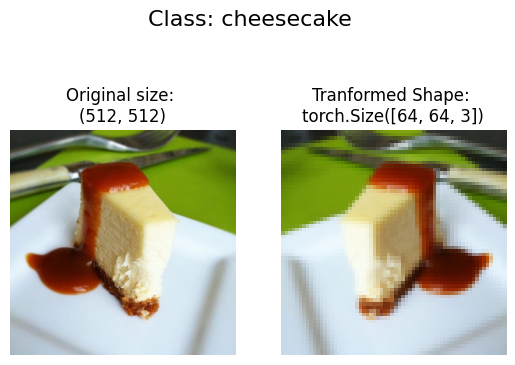

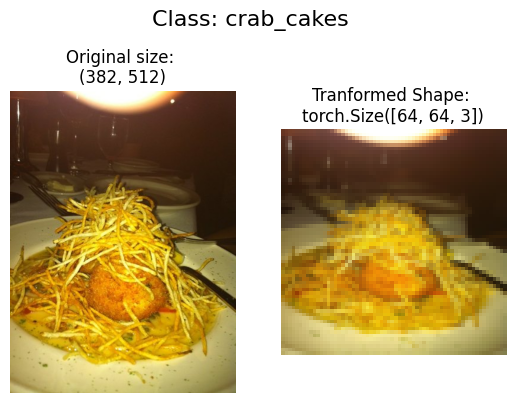

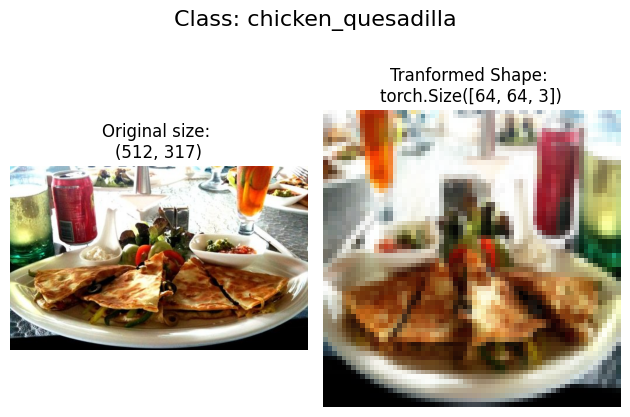

In [24]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths: list, transform: transforms, n=3, seed=None):
    """ 
    Selects Random Images from the paths and transforms them & plots the original vs tranformed.

    """
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths,k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original size: \n{f.size}")
            ax[0].axis('off')

            transformed_image = transform(f).permute(1,2,0) # as matplotlib accepts images in H,W,C, so (C,H,W) -> (H,W,C)
            print(type(transformed_image))
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Tranformed Shape: \n{transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

Note:
Here the transformed image has less information encoded in it, but this will help with faster computation.

We can use ImageFolder function if the data present in the directory is in this form:

- root/dog/456.png
- root/cat/123.png

In [25]:
train_dir = f'../dataset/MiniFood101/train'
test_dir = f'../dataset/MiniFood101/test'

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 7575
     Root location: ../dataset/MiniFood101/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2525
     Root location: ../dataset/MiniFood101/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [26]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

Text(0.5, 1.0, 'hamburger')

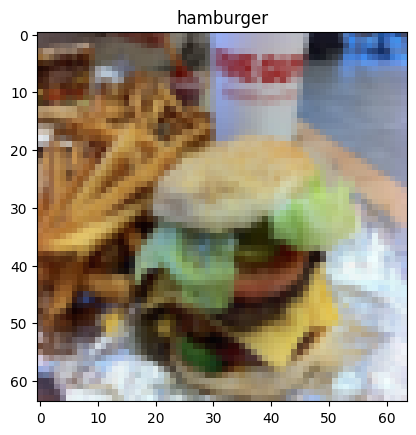

In [27]:
img, label = train_data[4007]
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])

Turn loaded images into dataloader

In [28]:
import os
os.cpu_count()

16

In [29]:
WORKERS = 4
BATCH_SIZE = 25

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=WORKERS,
                             shuffle=False)


In [30]:
len(train_dataloader), len(test_dataloader)

(303, 101)

In [31]:
img, label = next(iter(train_dataloader))

print(f"DataLoader Image shape: {img.shape}")

DataLoader Image shape: torch.Size([25, 3, 64, 64])


Lets Build our own 'DataSet'

- loads images from file
- gets class_name 
- gets classes as dictionary


In [32]:
from typing import Tuple, Dict, List

print(f"Directory: {train_dir}")

class_names_found = sorted([entry.name for entry in list(os.scandir(train_dir))]) 
class_names_found[0:10]


Directory: ../dataset/MiniFood101/train


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [33]:
def find_classes(directory: str) -> Tuple[List[str],Dict[str,int]]:
    ''' 
    Finds the class names in the target directory
    '''

    classes = sorted(entry.name for entry in list(os.scandir(train_dir)) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldnt find classes in the directory {train_dir}....")
    class_to_idx = {class_name:i for i,class_name in enumerate(classes) }

    return classes,class_to_idx 

From torch.utils.data.Dataset  

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite __getitem__(), supporting fetching a data sample for a given key. Subclasses could also optionally overwrite __len__(), which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement __getitems__(), for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.

In [61]:
from torch.utils.data import Dataset 

class ImageFolderCustom(Dataset):
    def __init__(self,
                 target_dir: str,
                 transform: None):
        
        super().__init__()
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.len_dataset = len(self.paths)
        self.transform = transform 
        self.classes,self.class_to_idx = find_classes(target_dir)
    
    def load_image(self, index: int) -> Image.Image:
        ''' 
        Opens an image and returns it
        '''
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        ''' 
        Return total number of samples
        '''
        return self.len_dataset
    
    def __getitem__(self,index: int) -> Tuple[torch.Tensor, int]:
        """ 
        Returns one sample of data, label. 
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img),class_idx 
        
        return img,class_idx
        



In [62]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [63]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transform)

In [64]:
train_data_custom[0][0].shape

torch.Size([3, 64, 64])

In [65]:
print(len(train_data),len(train_data_custom))
print(train_data.classes==train_data_custom.classes)
print(test_data.classes==test_data_custom.classes)

7575 7575
True
True


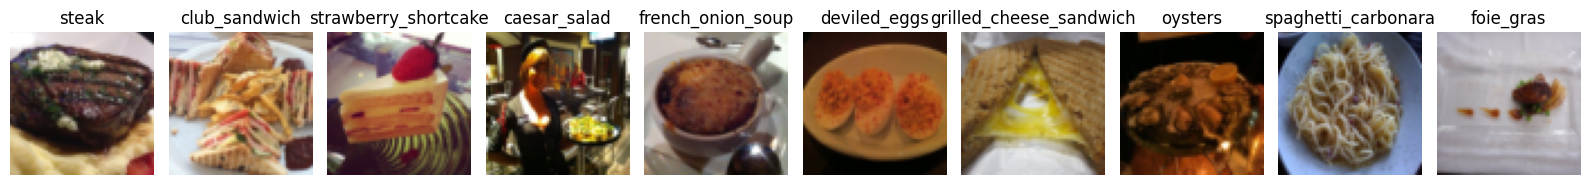

In [66]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int = 10):
    
    if n > 10:
        n = 10
        print('This function will not display images more than 10')
    
    # get random_indexes
    random_samples_idx = random.sample(range(len(dataset)),k=n)

    plt.figure(figsize=(16,8))
    # plt.title('64x64x3')

    for i,sample_idx in enumerate(random_samples_idx):
        image,label = dataset[sample_idx][0],dataset[sample_idx][1]

        adj_img = image.permute(1,2,0)

        plt.subplot(1,n,i+1)

        plt.imshow(adj_img)
        plt.axis('off')

        if classes:
            title = f"{classes[label]}"
            plt.title(title)
    
    plt.tight_layout()
    plt.axis('off')
    plt.show()
        

display_random_images(train_data_custom,train_data_custom.classes,10)    
    

Lets learn about data augmentation (To Artificially increase the diversity of data)

- Techniques used to increase the amount of data by adding slightly modified copies of the existing data or newly created synthetic data from the existing data.
- This helps model to be generalizable to unseen data.

In [75]:
# trivial_augmentation

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


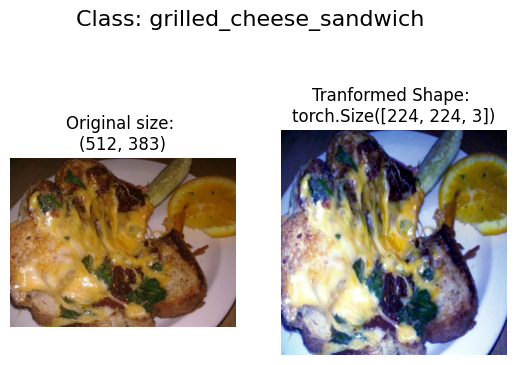

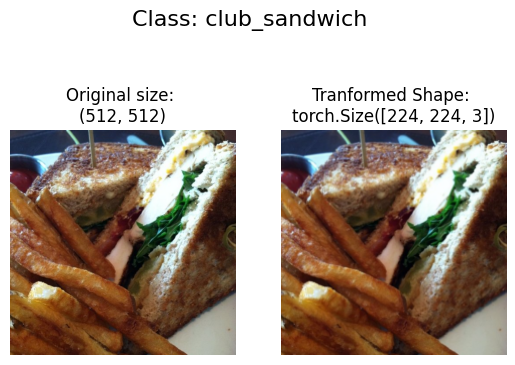

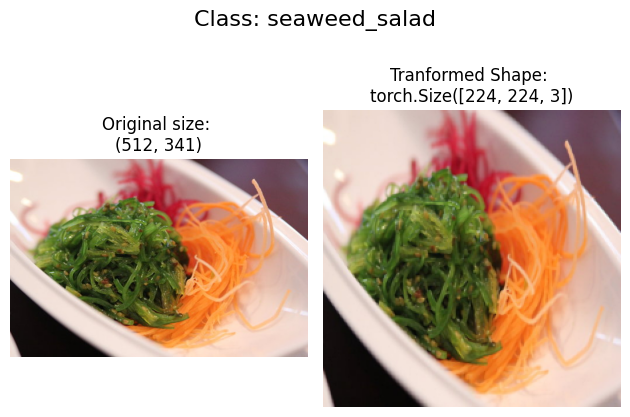

In [77]:
plot_transformed_images(image_paths=image_path_list,transform=train_transform,n=3)